In [ ]:
#Upload kaggle.json:
#Install the Kaggle library:
#! pip install kaggle

In [ ]:
#Make a directory named “.kaggle”:
#! mkdir ~/.kaggle

In [ ]:
#Copy the “kaggle.json” into this new directory:
#! cp kaggle.json ~/.kaggle/

In [ ]:
#Allocate the required permission for this file.:
#! chmod 600 ~/.kaggle/kaggle.json

In [1]:
#Download dataset emmarex/plantdisease from kaggle:
#! kaggle datasets download emmarex/plantdisease

In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive('/content/APPLEDISEASE.zip')

In [ ]:
#@title Default title text
#Unzip: /content/archive.zip
! unzip "/content/APPLEDISEASE.zip"

In [3]:
#!pip install -U label-studio
! file APPLEDISEASE.zip

APPLEDISEASE.zip: Zip archive data, at least v4.5 to extract


In [4]:
import cv2
import os

path = '/content/APPLE_DISEASE_DATASET'
images = []
for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path, filename))
    if img is not None:
        images.append(img)


In [5]:
for image in images:
    cv2.imshow('image', image)
    cv2.waitKey(10)
    cv2.destroyAllWindows()
    # use cv2.rectangle to draw a bounding box around the object or area that needs to be labeled


In [ ]:
'''path_labeled = '/content/dataset_labeled'
for i, image in enumerate(images):
    cv2.imwrite(os.path.join(path_labeled, 'labeled_{}.jpg'.format(i)), image)
    # save the label data to a CSV file or other format to associate the image file names with their corresponding labels
'''

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [7]:
#List of dir files:
os.listdir("/content/APPLE_DISEASE_DATASET")

['LEAF BLOTCH', 'APPLE ROT LEAVES', 'SCAB LEAVES', 'HEALTHY LEAVES']

In [8]:
#No. of files:
len(os.listdir("/content/APPLE_DISEASE_DATASET"))

4

In [36]:
#Training:
train = ImageDataGenerator(zoom_range = 0.5, shear_range = 0.3, rescale = 1/255, horizontal_flip = True, preprocessing_function = preprocess_input)

val = ImageDataGenerator(preprocessing_function = preprocess_input)

In [37]:
#target size = (w, h), batch size = data batch size
train = train.flow_from_directory(directory = "/content/APPLE_DISEASE_DATASET", target_size = (256, 256), batch_size = 32)
val = val.flow_from_directory(directory = "/content/APPLE_DISEASE_DATASET", target_size = (256, 256), batch_size = 32)

Found 419 images belonging to 4 classes.
Found 419 images belonging to 4 classes.


In [11]:
t_img, label = train.next()

In [12]:
t_img.shape

(32, 256, 256, 3)

In [13]:
def plotImage(img_arr, label):
  for img, l in zip(img_arr, label):
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.show()

In [ ]:
plotImage(t_img[:3], label[:3])

In [15]:
#Model:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [16]:
base_model = VGG19(input_shape = (256, 256, 3), include_top = False)

80134624/80134624 [==============================] - 4s 0us/step


In [27]:
for layer in base_model.layers:
  layer.trainable = False #Do not update weights. Feature extractor.

In [ ]:
base_model.summary()

In [31]:
X = Flatten()(base_model.output)
X = Dense(units = 4, activation = 'softmax')(X) # 4 classes so 4 units
model = Model(base_model.input, X)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [32]:
model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [33]:
#ModelCheckpoint = callback to save model weight at some frequency.
#EarlyStopping = Stop training when monitored metric stops improving.
#Monitor - metric to be monitored, min_delta - Acc must improve by (min change), patience - no of epochs to wait 
#before stopping if no improvement.
#verbose - level of detail of log messages.
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 3, verbose = 1)
#Filepath = path where best model should be saved.
#save_best_only - saves only best model.
mc = ModelCheckpoint(filepath = "Bestmodel.h5", monitor = "val_accuracy", 
                     min_delta = 0.01, patience = 3, verbose = 1, save_best_only = True)

#Callback:
cb = [es, mc]

In [38]:
his = model.fit_generator(train, steps_per_epoch = 14, epochs = 50, 
                          verbose = 1, callbacks = cb, 
                          validation_data = val, 
                          validation_steps = 14)

<ipython-input-38-63d241add8df>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train, steps_per_epoch = 14, epochs = 50,


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 2.1357 - accuracy: 0.3723
Epoch 1: val_accuracy improved from -inf to 0.38663, saving model to Bestmodel.h5
14/14 [==============================] - 27s 1s/step - loss: 2.1357 - accuracy: 0.3723 - val_loss: 17.0711 - val_accuracy: 0.3866
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.7433 - accuracy: 0.3866
Epoch 2: val_accuracy improved from 0.38663 to 0.49881, saving model to Bestmodel.h5
14/14 [==============================] - 12s 853ms/step - loss: 1.7433 - accuracy: 0.3866 - val_loss: 10.1985 - val_accuracy: 0.4988
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.4055 - accuracy: 0.4678
Epoch 3: val_accuracy did not improve from 0.49881
14/14 [==============================] - 11s 827ms/step - loss: 1.4055 - accuracy: 0.4678 - val_loss: 13.5510 - val_accuracy: 0.4773
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 1.1388 - accuracy: 0.5155
Epoch 4: v

In [39]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

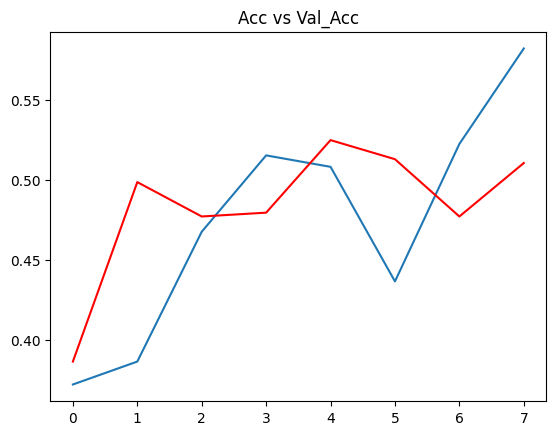

In [40]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("Acc vs Val_Acc")
plt.show()

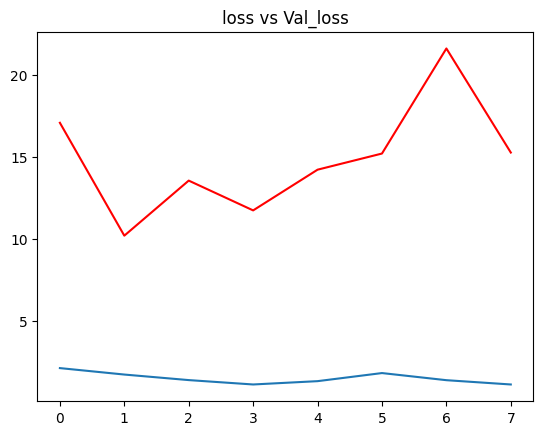

In [41]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs Val_loss")
plt.show()

In [42]:
#Loading the best model:
from keras.models import load_model
model = load_model("/content/Bestmodel.h5")

In [43]:
acc = model.evaluate_generator(val)[1]
print(f"Accuracy is {acc*100}%")

<ipython-input-43-6451b476329e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val)[1]


Accuracy is 52.505964040756226%


In [46]:
def prediction(path):
  img  = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)#VGG19 model
  img = np.expand_dims(im, axis = 0)#Extra dim of size 1 at axis 0
  pred = np.argmax(model.predict(img))#probability
  print(f"The image belongs to {ref[pred]}")

path = "/content/Scab_leaf.jpeg"
prediction(path)

1/1 [==============================] - 0s 18ms/step
The image belongs to SCAB LEAVES


In [45]:
#Reference:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))